S&P 500 — фондовый индекс, в корзину которого включено 505 избранных торгуемых на фондовых биржах США публичных компаний, имеющих наибольшую капитализацию. 

В своем проекте графически оценил нормальность скользящей выборки простого ежедневное процентного изменения цены закрытия. 
Рассчитал скользяющую коррелящию между индексом S&P 500 и объемами выкупа казначейский облигаций ФРС США. 
Рассчитал скользящую корреляцию между индексами S&P 500 и Russell 2000. 
Построил доверительный интервал для скользящего среднего S&P 500.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
plt.style.use('bmh')

In [2]:
SP = pd.read_csv('data/SnP500.csv').dropna()
RU = pd.read_csv('data/RUT.csv').dropna()
TR = pd.read_csv('data/TREAST.csv')

In [3]:
SP = SP[SP.Date > '2000-12-31']

Исходные данные для построения гистограмм скользящей выборки.

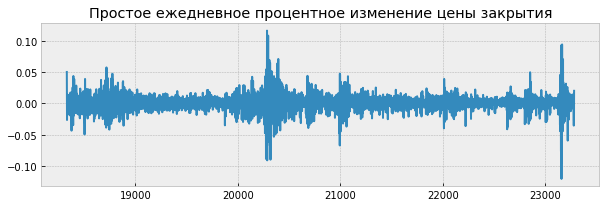

In [4]:
pm = SP.Close/SP.Close.shift(1) - 1

fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
ax.plot(pm)
plt.title('Простое ежедневное процентное изменение цены закрытия')
plt.show()

In [5]:
pm = pm.reset_index(drop=True)
SP.reset_index(drop=True, inplace=True)

Для построения гистограмм взял выборки размеров в 200. В период роста экономики распределение ближе к нормальному чем в периоды кризиса, при этом симметричность сохранятеся.

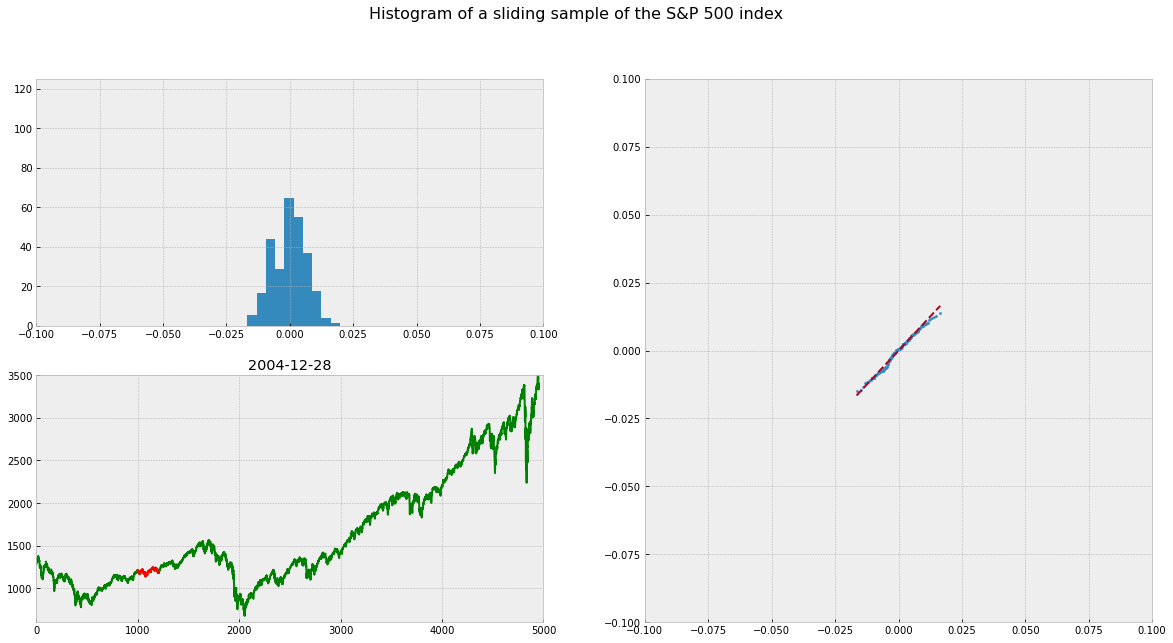

<Figure size 432x288 with 0 Axes>

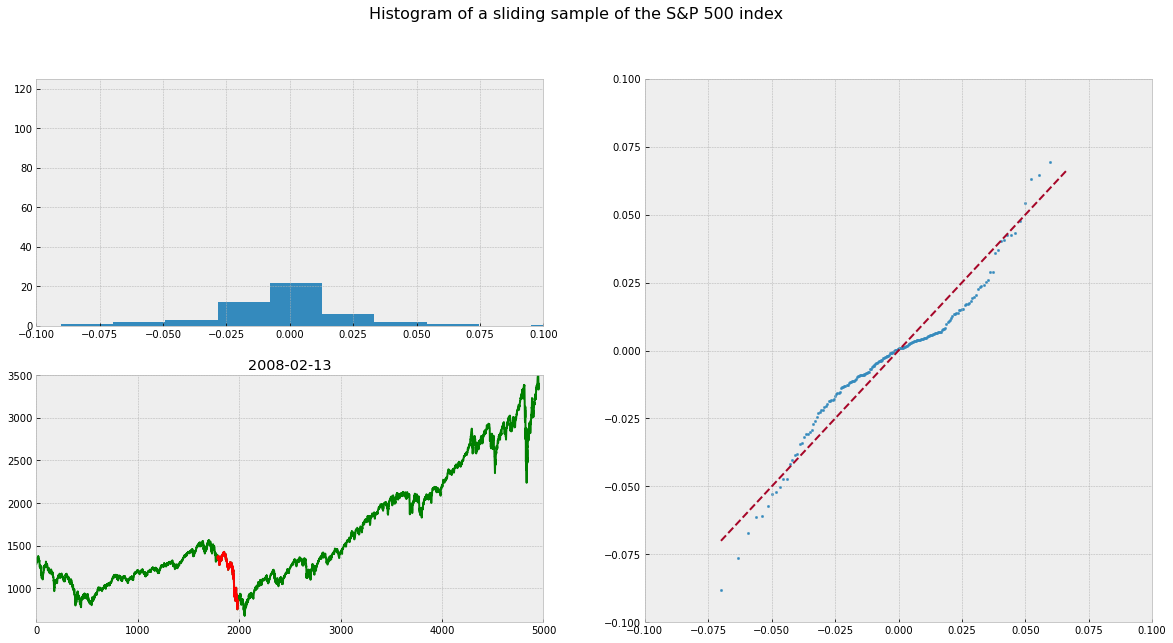

<Figure size 432x288 with 0 Axes>

In [6]:
win = 200

for i in (1000, 1787):
    arr = []
    arr.append(pm[i:i+win])
    
    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(20, 10)
    ax0 = plt.subplot2grid((2, 2), (0, 0))
    ax1 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0))
#     fig.subplots_adjust(wspace=0.2)
#     fig.subplots_adjust(hspace=0.2)
    
    ax0.hist(arr, bins=10, density=True)
    ax0.set_xlim([-0.1, 0.1])
    ax0.set_ylim([0, 125])
    fig.suptitle('Histogram of a sliding sample of the S&P 500 index', fontsize=16)
    
    ax2.plot(SP.Close, color='g')
    ax2.plot(SP.Close[i:i+win], color='r')
    ax2.set_ylim([600, 3500])
    ax2.set_xlim([0, 5000])
    ax2.set_title(f'{SP.Date[SP.index[i]]}')
    
    samples = np.array(arr)
    loc = samples.mean()
    scale = samples.std()
    interval = np.linspace(0, 1, samples.shape[1])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)

    ax1.scatter(x, y, s=5)
    ax1.plot(x, x, color='C1', linestyle='dashed')
    ax1.set_xlim([-0.1, 0.1])
    ax1.set_ylim([-0.1, 0.1])
    
    plt.show()
    plt.clf()
    
    

Тоже самое, но для каждого дня.

In [7]:
# win = 200

# for i in range(0, len(pm)):
#     arr = []
#     arr.append(pm[i:i+win])
    
#     fig, ax = plt.subplots(nrows=2, ncols=2)
#     fig.set_size_inches(20, 10)
#     ax0 = plt.subplot2grid((2, 2), (0, 0))
#     ax1 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
#     ax2 = plt.subplot2grid((2, 2), (1, 0))
# #     fig.subplots_adjust(wspace=0.2)
# #     fig.subplots_adjust(hspace=0.2)
    
#     ax0.hist(arr, bins=10, density=True)
#     ax0.set_xlim([-0.1, 0.1])
#     ax0.set_ylim([0, 125])
#     fig.suptitle('Histogram of a sliding sample of the S&P 500 index', fontsize=16)
    
#     ax2.plot(SP.Close, color='g')
#     ax2.plot(SP.Close[i:i+win], color='r')
#     ax2.set_ylim([600, 3500])
#     ax2.set_xlim([0, 5000])
#     ax2.set_title(f'{SP.Date[SP.index[i]]}')
    
#     samples = np.array(arr)
#     loc = samples.mean()
#     scale = samples.std()
#     interval = np.linspace(0, 1, samples.shape[1])[1:-1]
#     x = stats.norm.ppf(interval, loc=loc, scale=scale)
#     y = np.quantile(samples, interval)

#     ax1.scatter(x, y, s=5)
#     ax1.plot(x, x, color='C1', linestyle='dashed')
#     ax1.set_xlim([-0.1, 0.1])
#     ax1.set_ylim([-0.1, 0.1])
#     plt.savefig('E:/Temp/hist/{:04d}.png'.format(i))
#     plt.clf()

###Скользяющая коррелящия между скольязщим средним (с окном в 100) индекса S&P 500 и объемами выкупа казначейский облигаций ФРС США. 

Выкупая казначейские облигации ФРС осуществляет политику количественного смягчения. Заполняет выпадающий спрос во время кризиса, наводняя экономику деньгами. Но при этом инфляция не разгоняется. Существует мнение, что эти деньги по больше части уходят на рынок акций, попадая в реальную экономику лишь частично. В целом корреляция существует при уровне значимости в 0.01. Хотя кое-где есть и отрицательная корреляция. Для полноты картины надо бы еще учитвать QE от ЕЦБ и Банка Японии.

In [8]:
#Подгон 2х рядов друг к другу и подсчет корреляции
def rollcorr(x, y):
    x.index = x.Date
    y.index = y.Date
    y = y.drop('Date', axis=1)
    x = x.drop('Date', axis=1)
    if min(x.index) > min(y.index):
        min_date = min(x.index)
    else:
        min_date = min(y.index)
    x = x[x.index >= min_date]
    y = y[y.index >= min_date]
    y['Close_y'] = y['Close']
    y = y.drop('Close', axis=1)
#     xy = x.join(y)
    xy = pd.merge(x, y, how='left', on='Date')
#     xy = pd.concat([x, y], axis=1)
    xy.Close = xy.Close.fillna(method='ffill')
    xy.Close_y = xy.Close_y.fillna(method='ffill')
    corr = xy.Close.rolling(window=100, center=True).mean().rolling(window=100, center=True).corr(xy.Close_y)
    xy['corr'] = corr
    return xy

In [9]:
#Подсчет t-статистики для корреляции
def t_st(x):
    t = x['corr'] * (100 - 2)**(1/2)/(1 - x['corr']**2)**(1/2)
    t1 = stats.t.ppf(0.01/2, df=100 - 2)
    t2 = stats.t.ppf(1 - 0.01/2, df=100 - 2)

    corrt = pd.DataFrame({'corr': x['corr'], 't': t, 't1': np.ones(len(t))*t1, 't2': np.ones(len(t))*t2})
    return corrt

In [10]:
#Построение графиков двух рядов и корреляции с t-статистиой
def grapher(x):
    fig, ax = plt.subplots()
    ax.set_title('x и y')
    fig.set_size_inches(10, 5)
#     lns1 = ax.plot(x.Close.rolling(window=100, center=True).mean(), label='S&P 500')
    lns1 = ax.plot(x.Close, linewidth=1, label='x')
    ax2 = ax.twinx()
    lns2 = ax2.plot(x.Close_y, linewidth=1, c='g', label='y')

    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper left')

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    ax.set_title('Корреляция между x и y')
    ax2 = ax.twinx()
    lns1 = ax.plot(corrt.t, label='t-значение')
    lns2 = ax.plot(corrt.t1, linestyle=':', c='k', label='границы критической области')
    lns3 = ax.plot(corrt.t2, linestyle=':', c='k')
    lns4 = ax2.plot(corrt['corr'], linewidth=1, linestyle='--', c='r', label='корреляция')
    ax2.set_frame_on(True)

    lns = lns1+lns2+lns4
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc='upper left')

    plt.show()

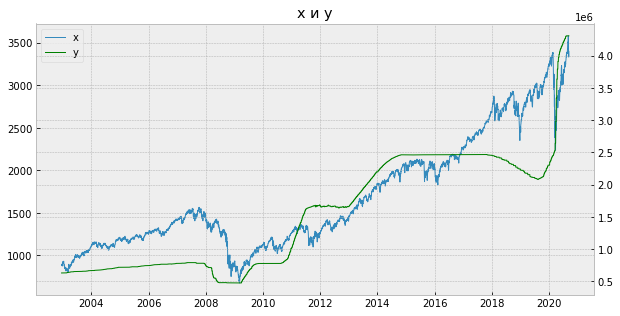

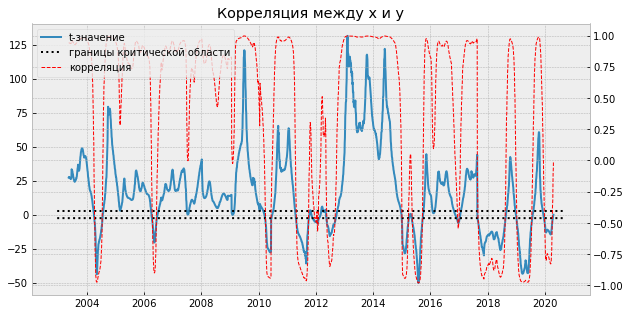

In [11]:
TR = TR.rename(columns={'DATE': 'Date', 'TREAST': 'Close'})
SP.Date = pd.to_datetime(SP.Date)
TR.Date = pd.to_datetime(TR.Date)
xy = rollcorr(SP, TR)
corrt = t_st(xy)
grapher(xy)

Построил диаграмму рассеяния, чтобы на глаз оценить линейную связь между этими двумя показателями, а также посчитал корреляцию за весь период. Видна по большей части прямая линейная зависиомть. Также есть четкий кусок отсутствия линейной зависимости.

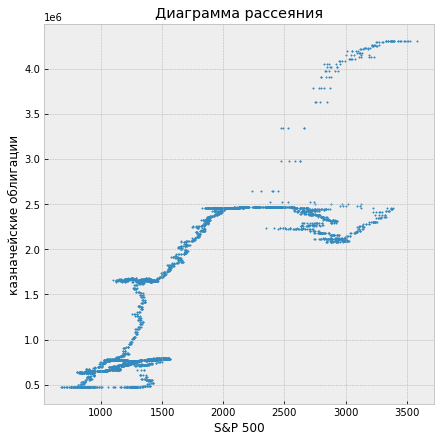

0.85380037973281

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(xy.Close, xy.Close_y, s=2)
plt.title('Диаграмма рассеяния')
plt.xlabel('S&P 500')
plt.ylabel('казначейские облигации')
plt.show()
xy.Close.corr(xy.Close_y)

###Скользящая коррелящия между индексом S&P 500 и Russell 2000 с окном в 100. 

Russell 2000 - фондовый индекс 2000 компаний среднего бизнеса. Корреляция между ними высокая. Большинство t-значений корреляции находится в критической области при уровне значимости в 0.01.

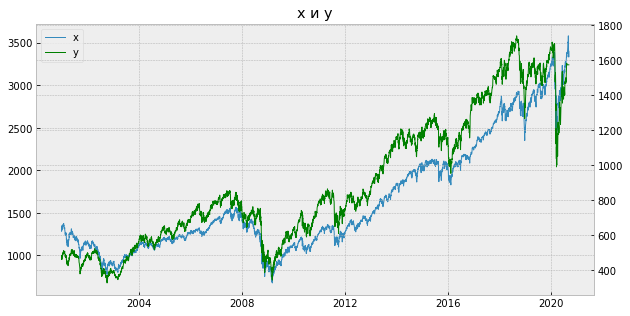

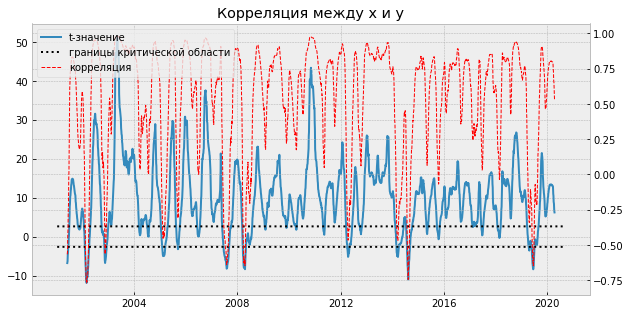

In [13]:
SP.Date = pd.to_datetime(SP.Date)
RU.Date = pd.to_datetime(RU.Date)
xy = rollcorr(SP, RU)
corrt = t_st(xy)
grapher(xy)

Построил диаграмму рассеяния, чтобы на глаз оценить линейную связь между этими двумя показателями, а также посчитал корреляцию за весь период. Видна прямая линейная зависимость.

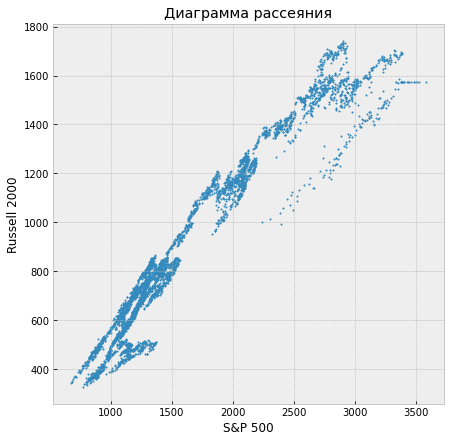

0.9688310638181299

In [14]:
plt.figure(figsize=(7,7))
plt.scatter(xy.Close, xy.Close_y, s=2)
plt.title('Диаграмма рассеяния')
plt.xlabel('S&P 500')
plt.ylabel('Russell 2000')
plt.show()
xy.Close.corr(xy.Close_y)

###Доверительный интервал для скользящего среднего S&P 500.

Посчитал доверительный интервал для скользящего среднего S&P 500 с надежностью в 0.99. Выборка с начала 2020 года. Также добавил исходные данные.

In [15]:
win = 10

SP['rollm'] = SP.Close.rolling(window=win, center=True).mean()
SP['rollstd'] = SP.Close.rolling(window=win, center=True).std()

alpha = 0.001

t1 = stats.t.ppf(alpha / 2, df=win - 1)
t2 = stats.t.ppf(1 - alpha / 2, df=win - 1)

SP['t1'] = SP.rollm + t1*SP.rollstd/(win**(1/2))
SP['t2'] = SP.rollm + t2*SP.rollstd/(win**(1/2))

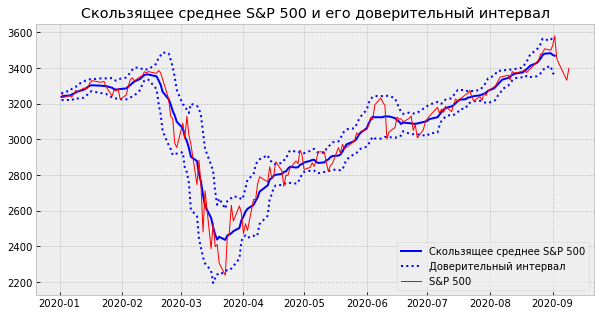

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 5)

ax.plot(SP.rollm[SP.index > '2020'], label='Скользящее среднее S&P 500', c='b')
ax.plot(SP.t1[SP.index > '2020'], linestyle=':', c='b', label='Доверительный интервал')
ax.plot(SP.t2[SP.index > '2020'], linestyle=':', c='b')
ax.plot(SP.Close[SP.index > '2020'], linewidth=1, c='r', label='S&P 500')
ax.set_title('Скользящее среднее S&P 500 и его доверительный интервал')
ax.legend()

plt.show()